In [1]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.sparse.linalg import eigsh
from tensorflow import keras
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import NearestNeighbors
from torchvision import models
from scipy.sparse import csr_matrix

# Features

In [2]:
X_train = np.load(r'C:\Users\Test\Desktop\p7\Spectral\features\train_features_vgg16_cifar10.npy')
X_test = np.load(r'C:\Users\Test\Desktop\p7\Spectral\features\test_features_vgg16_cifar10.npy')
y_train = np.load(r'C:\Users\Test\Desktop\p7\Spectral\features\train_labels_vgg16_cifar10.npy')
y_test = np.load(r'C:\Users\Test\Desktop\p7\Spectral\features\test_labels_vgg16_cifar10.npy')

In [3]:
X_val = X_train[-5000:,:]
X_train = X_train[:-5000,:]
y_val = y_train[-5000:]
y_train = y_train[:-5000]

In [4]:
np.save(r'C:\Users\Test\Desktop\p7\Spectral\features\train_features_vgg16_cifar10.npy', X_train)
np.save(r'C:\Users\Test\Desktop\p7\Spectral\features\val_features_vgg16_cifar10.npy', X_val)
np.save(r'C:\Users\Test\Desktop\p7\Spectral\features\train_labels_vgg16_cifar10.npy', y_train)
np.save(r'C:\Users\Test\Desktop\p7\Spectral\features\val_labels_vgg16_cifar10.npy', y_val)

In [5]:
y_val.shape

(5000,)

In [6]:
X_train.shape

(40000, 4096)

# PCA

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Standardize the data
X_test = scaler.transform(X_test)

In [8]:
pca = PCA(n_components=100)  # Set the number of components to keep
training_features = pca.fit_transform(X_train)  # Fit PCA on the standardized data and transform
test_features = pca.transform(X_test)

# Spectral

In [9]:
nbrs = NearestNeighbors(n_neighbors=150).fit(training_features)

# Find the nearest neighbors
distances, indices = nbrs.kneighbors(training_features)

# Create an adjacency matrix
n_samples = training_features.shape[0]
adjacency_matrix = np.zeros((n_samples, n_samples))

# Populate the adjacency matrix
for i, neighbors in enumerate(indices):
    for neighbor in neighbors:
        adjacency_matrix[i, neighbor] = 1
        adjacency_matrix[neighbor, i] = 1  # Ensure symmetry for an undirected graph

In [10]:
dim=adjacency_matrix.shape[0]
adjacency_matrix = adjacency_matrix - np.identity(dim)

D = np.zeros([dim,dim])
for i in tqdm(range(dim)):
    D[i,i] = adjacency_matrix[i].sum()
L = D- adjacency_matrix    

L= csr_matrix(L)


100%|██████████| 40000/40000 [00:03<00:00, 10835.57it/s]


In [26]:
eigenvalues, eigenvectors = eigsh(L, k=64,which="SM") # overvej max_iter, tolerance?

In [12]:
eigenvectors = eigenvectors[:,1:]

In [13]:
threshold1 = 0
eigenvectors_bin = np.where(eigenvectors > threshold1, 1, -0)

In [14]:
test_features.shape

(10000, 100)

# Classifier

In [27]:
clf = MLPClassifier(hidden_layer_sizes=(100), max_iter = 1000).fit(training_features, eigenvectors_bin)
test_hashes = clf.predict(test_features)

In [16]:
def mean_average_precision(test_hashes, training_hashes, test_labels, training_labels):
    aps = []
    for i, test_hash in enumerate(tqdm(test_hashes)):
        label = test_labels[i]
        distances = np.abs(training_hashes - test_hashes[i]).sum(axis=1)
        tp = np.where(training_labels==label, 1, 0)
        hash_df = pd.DataFrame({"distances":distances, "tp":tp}).reset_index()
        hash_df = hash_df.sort_values(["distances", "index"]).reset_index(drop=True)
        hash_df = hash_df.drop(["index", "distances"], axis=1).reset_index()
        hash_df = hash_df[hash_df["tp"]==1]
        hash_df["tp"] = hash_df["tp"].cumsum()
        hash_df["index"] = hash_df["index"] +1 
        precision = np.array(hash_df["tp"]) / np.array(hash_df["index"])
        ap = precision.mean()
        aps.append(ap)
    
    return np.array(aps).mean()

In [17]:
def p_at_k(test_hashes, training_hashes, test_labels, training_labels, compare_n, ks):
    k_dic = {k:[] for k in ks}
    training_hashes = training_hashes[:compare_n,:]
    training_labels = training_labels[:compare_n]
    for i, test_hash in enumerate(tqdm(test_hashes)):
        label = test_labels[i]
        distances = np.abs(training_hashes - test_hashes[i]).sum(axis=1)
        tp = np.where(training_labels==label, 1, 0)
        hash_df = pd.DataFrame({"distances":distances, "tp":tp}).reset_index()
        hash_df = hash_df.sort_values(["distances", "index"]).reset_index(drop=True)
        for k in ks:
            df_temp = hash_df[:k]
            patk = df_temp["tp"].sum()/k
            k_dic[k].append(patk)
    return tuple([np.array(k_dic[k]).mean() for k in ks])

In [28]:
aps = mean_average_precision(test_hashes, eigenvectors_bin, y_test, y_train)
aps

100%|██████████| 10000/10000 [01:37<00:00, 102.18it/s]


0.2717269951732152

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

# Step 1: Perform K-Means Clustering
def kmeans_clustering(hash_codes, n_clusters=10, n_init=10, random_state=42):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=random_state)
    clusters = kmeans.fit_predict(hash_codes)
    return clusters

# Step 2: Build the label-cluster matrix
def build_label_cluster_matrix(clusters, true_labels, n_clusters=10):
    # Initialize a matrix to count label-cluster relationships  
    label_cluster_matrix = np.zeros((10, n_clusters), dtype=int)
    
    for label, cluster in zip(true_labels, clusters):
        label_cluster_matrix[label][cluster] += 1
    
    return label_cluster_matrix

# Step 3: Visualize the result as a heatmap
def plot_heatmap(label_cluster_matrix):
    plt.figure(figsize=(10, 6))
    sns.heatmap(label_cluster_matrix, annot=True, fmt="d", cmap="Blues", cbar=True)
    plt.title("Label Distribution Across Clusters")
    plt.xlabel("Clusters")
    plt.ylabel("True Labels")
    plt.show()


def easyHeatmap(hashCodes, labels):
    raw_clusters = kmeans_clustering(hashCodes, n_clusters=10)

    raw_label_cluster_matrix = build_label_cluster_matrix(raw_clusters, labels)

    plot_heatmap(raw_label_cluster_matrix)

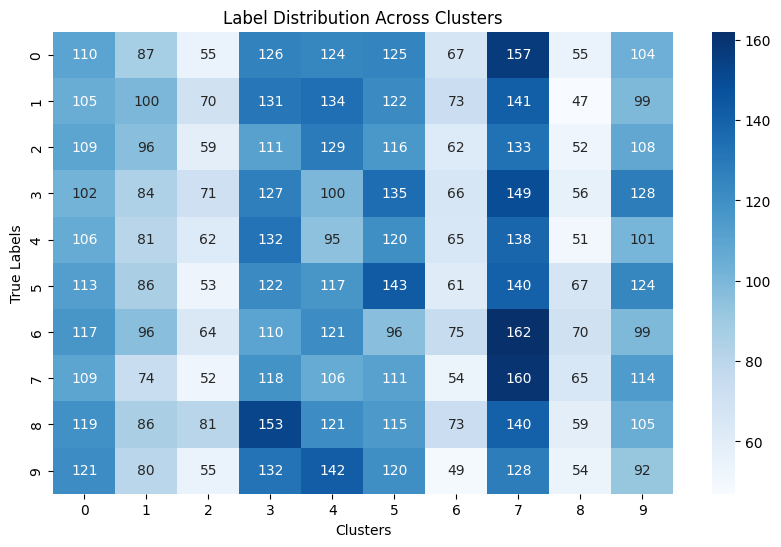

In [29]:
easyHeatmap(test_hashes, y_train)